In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import stats
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-13-f34df45a857e>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [14]:
data=np.loadtxt(open('/content/sample_data/mnist_train_small.csv'),delimiter=(','))
data

array([[6., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [15]:
data.shape

(20000, 785)

In [16]:
label=data[:,0]
data=data[:,1:]
print(label.shape)
print(data.shape)

(20000,)
(20000, 784)


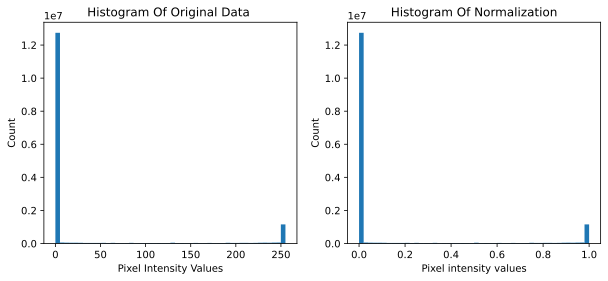

In [17]:
datanorm=data/np.max(data)

fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram Of Original Data ')
ax[1].hist(datanorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram Of Normalization')

plt.show()

In [18]:
dataT=torch.tensor(datanorm).float()
labelT=torch.tensor(label).long()

train_data,test_data,train_label,test_label=train_test_split(dataT,labelT,test_size=.1)

train_data=TensorDataset(train_data,train_label)
test_data=TensorDataset(test_data,test_label)

batch_size=32
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [19]:
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                       ndarray          2: 2 elems, type `object`, 16 bytes
batch_size               int              32
creat_ann_model          function         <function creat_ann_model at 0x7e6f996d4ee0>
data                     ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT                    Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
datanorm                 ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
display                  module           <module 'IPython.display'<..

In [20]:
def creat_ann_model():
  class mnist(nn.Module):
    def __init__(self):
      super(mnist,self).__init__()

      self.input=nn.Linear(784,64)
      self.fc1=nn.Linear(64,32)
      self.fc2=nn.Linear(32,32)
      self.output=nn.Linear(32,10)

    def forward(self,x):
      x=F.relu(self.input(x))
      x=F.relu(self.fc1(x))
      x=F.relu(self.fc2(x))
      return F.log_softmax(self.output(x),dim=1)
  net=mnist()
  lossfunc=nn.NLLLoss()
  optimizer=torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfunc,optimizer

In [21]:
net,lossfunc,optimizer=creat_ann_model()
x,y=next(iter(train_loader))
yhat=net(x)
print(x)
print('')
loss=lossfunc(yhat,y)
print('')
print('loss is :')
print(loss)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


loss is :
tensor(2.3156, grad_fn=<NllLossBackward0>)


In [22]:
def function2trainThemodel():
  num_epochs=60
  net,lossfunc,optimizer=creat_ann_model()

  losses=torch.zeros(num_epochs)
  train_acc=[]
  test_acc=[]

  for epochi in range(num_epochs):

    batch_acc=[]
    batch_losses=[]

    for x,y in train_loader:
      yhat=net(x)
      loss=lossfunc(yhat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_losses.append(loss.item())
      batch_acc.append(100*torch.mean((torch.argmax(yhat,axis=1)==y).float()).item())

    train_acc.append(np.mean(batch_acc))
    losses[epochi]=np.mean(batch_losses)
    x,y=next(iter(test_loader))
    yhat=net(x)
    test_acc.append(100*torch.mean((torch.argmax(yhat,axis=1)==y).float()).item())

  return train_acc,test_acc,losses,net


In [23]:
train_acc,test_acc,losses,net=function2trainThemodel()

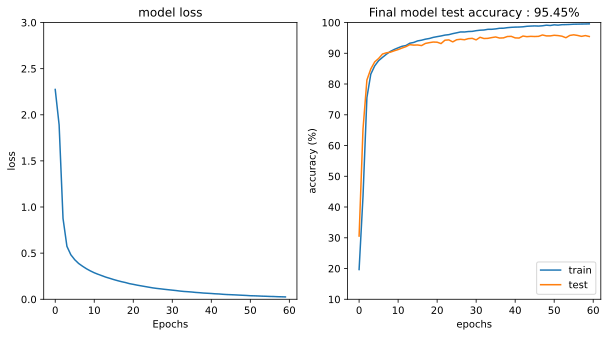

In [24]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('loss')
ax[0].set_ylim([0,3])
ax[0].set_title('model loss')
ax[1].plot(train_acc,label='train')
ax[1].plot(test_acc,label='test')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy : {test_acc[-1]:.2f}%')
ax[1].legend()
plt.show()

In [27]:
x,y=next(iter(test_loader))
pred=net(x).detach()
torch.exp(pred)

tensor([[1.0839e-06, 2.3282e-03, 2.6181e-06,  ..., 1.4282e-03, 1.3355e-01,
         6.8337e-01],
        [9.9996e-01, 7.4574e-14, 4.0720e-05,  ..., 1.1907e-09, 4.9740e-09,
         1.5637e-10],
        [1.3543e-11, 3.7821e-11, 3.3027e-12,  ..., 1.5889e-10, 9.8307e-10,
         3.0504e-05],
        ...,
        [3.0964e-09, 9.6035e-08, 7.0303e-10,  ..., 8.4664e-05, 4.7613e-06,
         9.9964e-01],
        [4.0396e-11, 5.6603e-09, 9.5239e-10,  ..., 6.3530e-11, 2.6001e-09,
         8.5734e-07],
        [5.0309e-05, 7.1799e-08, 5.6246e-06,  ..., 7.6824e-14, 8.1136e-04,
         2.1601e-08]])

Text(0, 0.5, 'evidence for that number')

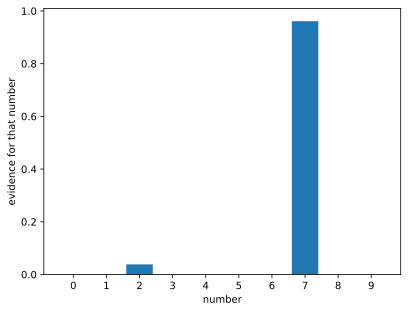

In [29]:
sample4show=120
plt.bar(range(10),torch.exp(pred[sample4show]))
plt.xticks(range(10))
plt.xlabel('number')
plt.ylabel('evidence for that number')

[   0    9   28   35   61   82   98  100  112  144  195  216  232  261
  317  331  336  344  351  404  425  437  441  445  465  469  509  523
  528  569  607  617  699  716  725  772  820  848  872  875  922  928
  948  984  990  998  999 1019 1043 1052 1054 1057 1058 1069 1078 1154
 1174 1212 1315 1335 1357 1383 1461 1464 1468 1495 1501 1503 1575 1583
 1596 1611 1620 1621 1683 1701 1702 1724 1728 1784 1788 1798 1811 1824
 1832 1843 1851 1857 1923 1929 1970]


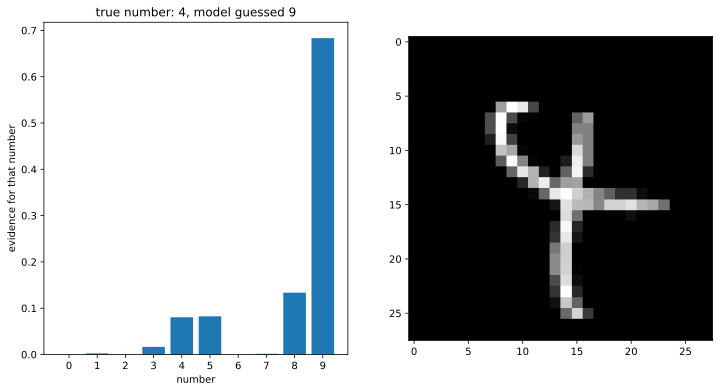

In [40]:
pred=net(x).detach()
errors=np.where(torch.max(pred,axis=1)[1]!=y)[0]
print(errors)
sample4show=0
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].bar(range(10),np.exp(pred[errors[sample4show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('number')
ax[0].set_ylabel('evidence for that number')
ax[0].set_title('true number: %s, model guessed %s'
                %(y[errors[sample4show]].item(),torch.argmax(pred[errors[sample4show]]).item()))
ax[1].imshow(np.reshape(x[errors[sample4show],:],(28,28)),cmap='gray')